In [1]:
import numpy as np 
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt 
import seaborn as sns

sns.set()
%matplotlib inline

In [2]:
df = pd.read_csv('monthly-milk-production-pounds-p.csv')

In [3]:
df.head()

,Month,Monthly milk production: pounds per cow. Jan 62 ? Dec 75
0,1962-01,589.0
1,1962-02,561.0
2,1962-03,640.0
3,1962-04,656.0
4,1962-05,727.0


In [4]:
# Clean up
# Rename columns
df.columns = ['Month','Milk in Pounds per Cow']

In [5]:
df.head()

,Month,Milk in Pounds per Cow
0,1962-01,589.0
1,1962-02,561.0
2,1962-03,640.0
3,1962-04,656.0
4,1962-05,727.0


In [6]:
df.tail()

,Month,Milk in Pounds per Cow
164,1975-09,817.0
165,1975-10,827.0
166,1975-11,797.0
167,1975-12,843.0
168,Monthly milk production: pounds per cow. Jan 6...,NaN


In [7]:
# Drop the trailing line 168
df.drop(168,axis=0,inplace=True)

In [8]:
# Convert Month to be a datetime index 
# First convert Month to a date-time type
df['Month'] = pd.to_datetime(df['Month'])
# Now create a datetime index from it
df.set_index('Month', inplace=True)

In [9]:
df.index

DatetimeIndex(['1962-01-01', '1962-02-01', '1962-03-01', '1962-04-01',
               '1962-05-01', '1962-06-01', '1962-07-01', '1962-08-01',
               '1962-09-01', '1962-10-01',
               ...
               '1975-03-01', '1975-04-01', '1975-05-01', '1975-06-01',
               '1975-07-01', '1975-08-01', '1975-09-01', '1975-10-01',
               '1975-11-01', '1975-12-01'],
              dtype='datetime64[ns]', name='Month', length=168, freq=None)

In [10]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Milk in Pounds per Cow,168.0,754.708333,102.204524,553.0,677.75,761.0,824.5,969.0


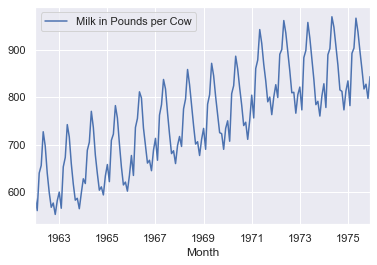

In [11]:
# What does the data look like
df.plot()

In [12]:
# Create series
time_series = df['Milk in Pounds per Cow']
type(time_series)

pandas.core.series.Series

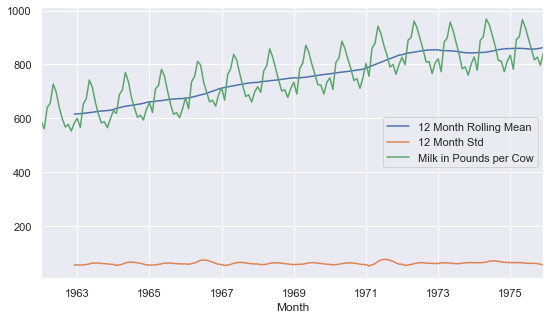

In [13]:
# 12 month rolling average
time_series.rolling(12).mean().plot(label='12 Month Rolling Mean',figsize=(9,5))
time_series.rolling(12).std().plot(label='12 Month Std')
time_series.plot(label="Milk in Pounds per Cow")
plt.legend()

# Its a good sign that the dataset is workable if the Std deviation is relatively
# flat in comparison to the main dataset

In [14]:
from statsmodels.tsa.seasonal import seasonal_decompose

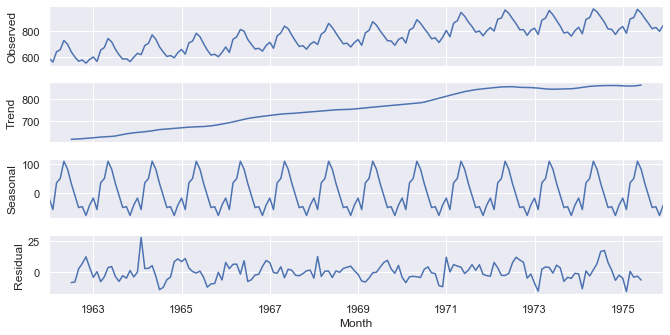

In [15]:
decomp = seasonal_decompose(time_series,freq=12)
fig = decomp.plot()
fig.set_size_inches(10,5)

In [16]:
# Using Mathmatical techniques to tell if the data is stationary, such as the Augmented Dicky Fuller Unit Root test
# (Eyeballing the chart, we can see that its not stationary)
# A small p value < 0.05 returned gives strong evidence that the data is stationary

from statsmodels.tsa.stattools import adfuller


In [17]:
result = adfuller(df['Milk in Pounds per Cow'])
result

(-1.3038115874221294,
 0.6274267086030316,
 13,
 154,
 {'1%': -3.473542528196209,
  '5%': -2.880497674144038,
  '10%': -2.576878053634677},
 1115.1730447395112)

In [18]:
def adf_check(time_series):
    """
    Peforms the Augmented Dicky-Fuller test to find out if
    the data is stationary or not.
    """
    result = adfuller(time_series)
    print(" Augmented Dicky-Fuller Test")
    labels = ['ADF Test Statistic','p-value','# of lags','Num of Observations used']

    # Can this be rewritten more efficiently and used as a dictionary?
    for value, label in zip(result, labels):
        print(f"{label}: {str(value)}")
    
    if result[1] <= 0.05:
        print("Strong evidence against null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root, it is non-stationary")


In [19]:
adf_check(df['Milk in Pounds per Cow'])

Augmented Dicky-Fuller Test
ADF Test Statistic: -1.3038115874221294
p-value: 0.6274267086030316
# of lags: 13
Num of Observations used: 154
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root, it is non-stationary


In [37]:
# As its non stationary, we'll 'difference' the data until it becomes stationary
df['First Difference'] = df['Milk in Pounds per Cow'] - df['Milk in Pounds per Cow'].shift(1)

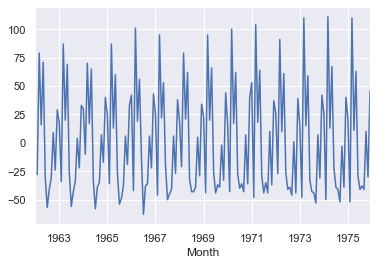

In [38]:
df['First Difference'].plot()


In [22]:
adf_check(df['First Difference'].dropna())

Augmented Dicky-Fuller Test
ADF Test Statistic: -3.0549955586530264
p-value: 0.030068004001789234
# of lags: 14
Num of Observations used: 152
Strong evidence against null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


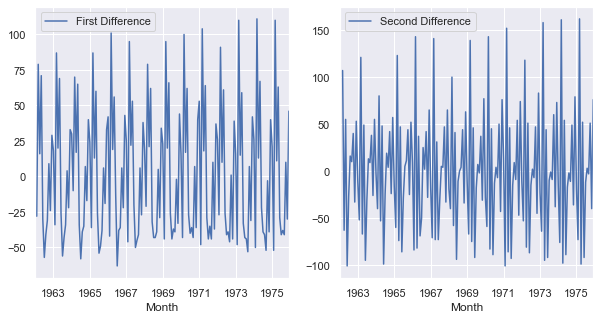

In [23]:
# Example of how to get the second and subsequent differences
df['Second Difference'] = df['First Difference'] - df['First Difference'].shift(1)
fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(10,5))
df['First Difference'].plot(x='Month',y=df['First Difference'],ax=ax[0],legend='Diff 1')
df['Second Difference'].plot(x='Month',y=df['Second Difference'],ax=ax[1], legend='Diff 2')

In [24]:
# Now if we run the 2nd diffence through the Augmented Dicky Fuller test, we get the same result
# but 'over differencing' removes information from the data, so in this case, it is unnecessary
#########################################################################################
# If you don use the .dropna() method, you get a very long error string ending 
# with "MissingDataError: exog contains inf or nans"
######################################################################################

adf_check(df['Second Difference'].dropna())


Augmented Dicky-Fuller Test
ADF Test Statistic: -14.327873645603406
p-value: 1.1126989332080276e-26
# of lags: 11
Num of Observations used: 154
Strong evidence against null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [25]:
# Work on Seasonal Differences
df['Seasonal Difference'] = df['Milk in Pounds per Cow'] - df['Milk in Pounds per Cow'].shift(12)

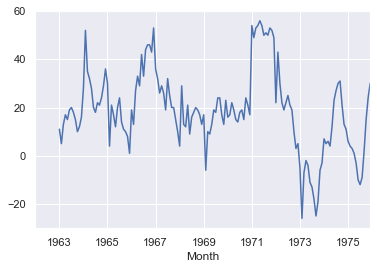

In [26]:
df['Seasonal Difference'].plot()

In [27]:
adf_check(df['Seasonal Difference'].dropna())

Augmented Dicky-Fuller Test
ADF Test Statistic: -2.3354193143593998
p-value: 0.16079880527711288
# of lags: 12
Num of Observations used: 143
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root, it is non-stationary


In [32]:
# The result from Seasonal Differnce is that its 'not stationary' 
# so we'll do a second difference
df['Seasonal First Difference'] = df['First Difference'] - df['First Difference'].shift(12)

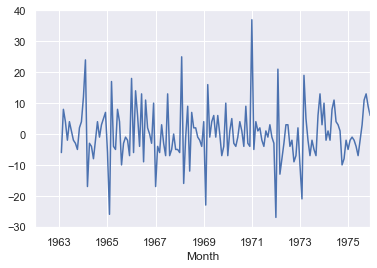

In [33]:
df['Seasonal First Difference'].plot()

In [34]:
adf_check(df['Seasonal First Difference'].dropna())

Augmented Dicky-Fuller Test
ADF Test Statistic: -5.0380022749219755
p-value: 1.865423431878904e-05
# of lags: 11
Num of Observations used: 143
Strong evidence against null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [35]:
# Auto Correlation Plots Function (ACF) and Partial Auto Correlation Function Plots (PACF)
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


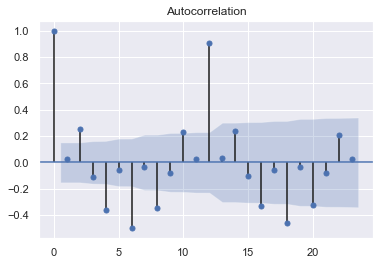

In [39]:
fig_first = plot_acf(df['First Difference'].dropna())

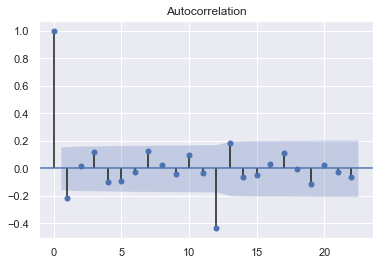

In [40]:
fig_seasonal_first = plot_acf(df['Seasonal First Difference'].dropna()) 

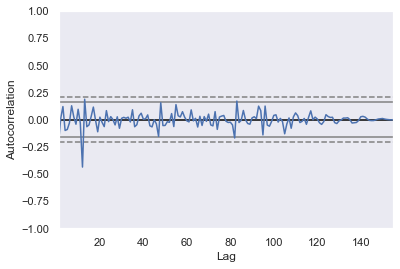

In [41]:
# ACF (only) can be done directly from pandas
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df['Seasonal First Difference'].dropna())


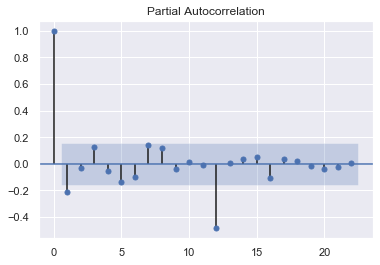

In [43]:
# PACF plots
result = plot_pacf(df['Seasonal First Difference'].dropna())

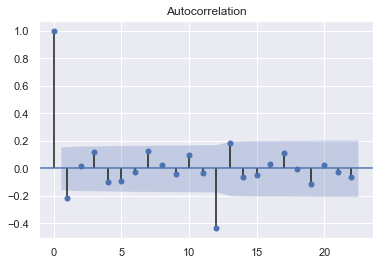

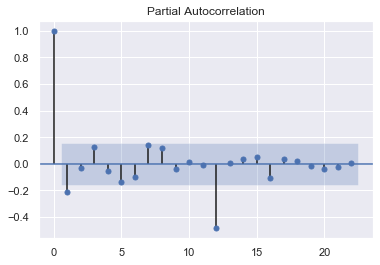

In [45]:
plot_acf(df['Seasonal First Difference'].dropna())
result = plot_pacf(df['Seasonal First Difference'].dropna())


In [48]:
from statsmodels.tsa.arima_model import ARIMA
help(ARIMA)

Help on class ARIMA in module statsmodels.tsa.arima_model:

class ARIMA(ARMA)
 |  ARIMA(endog, order, exog=None, dates=None, freq=None, missing='none')
 |  
 |  Autoregressive Integrated Moving Average ARIMA(p,d,q) Model
 |  
 |  Parameters
 |  ----------
 |  endog : array-like
 |      The endogenous variable.
 |  order : iterable
 |      The (p,d,q) order of the model for the number of AR parameters,
 |      differences, and MA parameters to use.
 |  exog : array-like, optional
 |      An optional array of exogenous variables. This should *not* include a
 |      constant or trend. You can specify this in the `fit` method.
 |  dates : array-like of datetime, optional
 |      An array-like object of datetime objects. If a pandas object is given
 |      for endog or exog, it is assumed to have a DateIndex.
 |  freq : str, optional
 |      The frequency of the time-series. A Pandas offset or 'B', 'D', 'W',
 |      'M', 'A', or 'Q'. This is optional if dates are given.
 |  
 |  
 |  Notes


In [49]:
# Using the Seasonal Arima model from StatsModel 
model = sm.tsa.SARIMAX(df['Milk in Pounds per Cow'], order=(0,1,0), seasonal_order=(1,1,1,12))

E:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [50]:
results = model.fit()

In [51]:
print(results.summary())

Statespace Model Results                                 
Dep. Variable:             Milk in Pounds per Cow   No. Observations:                  168
Model:             SARIMAX(0, 1, 0)x(1, 1, 1, 12)   Log Likelihood                -534.065
Date:                            Thu, 09 Apr 2020   AIC                           1074.131
Time:                                    07:50:20   BIC                           1083.261
Sample:                                01-01-1962   HQIC                          1077.839
                                     - 12-01-1975                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.0449      0.106     -0.422      0.673      -0.253       0.163
ma.S.L12      -0.5860      0.102     -5.762      0.000      -0.785  

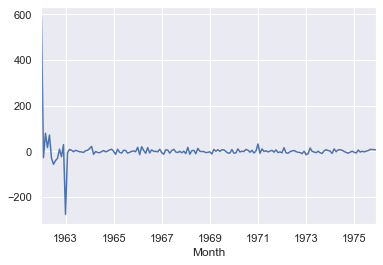

In [52]:
# Show the residual values (the error between what it predicted and and the actual Milk production values)
results.resid.plot() 

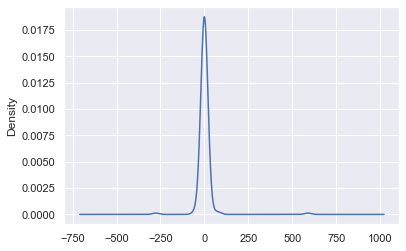

In [54]:
# KDE chart shows that the prediction errors are concentrated around 0
results.resid.plot(kind='kde')  


In [57]:
# What is it actually forecasting for the our current data
df['forecast'] = results.predict(start=100, end=180)  # what are the Start and end..


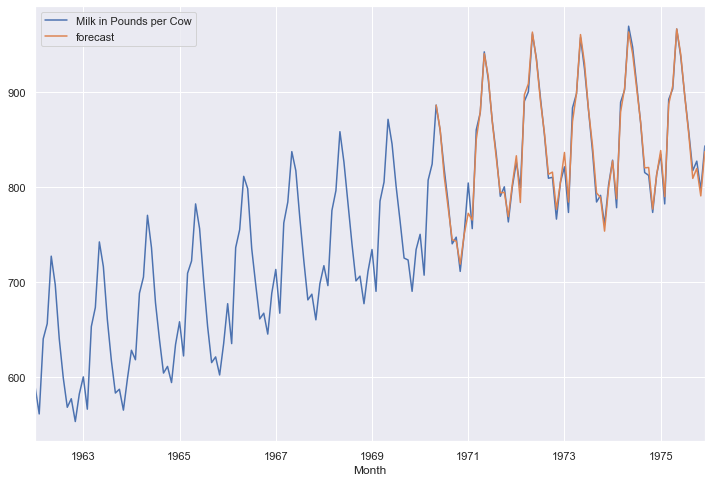

In [58]:
# Plot the actual v forecast production
df[['Milk in Pounds per Cow','forecast']].plot(figsize=(12,8))

In [59]:
# We need to add addional months empty rows to the dataframe in order to 
# be able to forecast future production beyond December 1975 (current last row)
from pandas.tseries.offsets import DateOffset

In [61]:
# using a list comprehension
future_dates = [df.index[-1] + DateOffset(months=x) for x in range(1,24)]
future_dates

[Timestamp('1976-01-01 00:00:00'),
 Timestamp('1976-02-01 00:00:00'),
 Timestamp('1976-03-01 00:00:00'),
 Timestamp('1976-04-01 00:00:00'),
 Timestamp('1976-05-01 00:00:00'),
 Timestamp('1976-06-01 00:00:00'),
 Timestamp('1976-07-01 00:00:00'),
 Timestamp('1976-08-01 00:00:00'),
 Timestamp('1976-09-01 00:00:00'),
 Timestamp('1976-10-01 00:00:00'),
 Timestamp('1976-11-01 00:00:00'),
 Timestamp('1976-12-01 00:00:00'),
 Timestamp('1977-01-01 00:00:00'),
 Timestamp('1977-02-01 00:00:00'),
 Timestamp('1977-03-01 00:00:00'),
 Timestamp('1977-04-01 00:00:00'),
 Timestamp('1977-05-01 00:00:00'),
 Timestamp('1977-06-01 00:00:00'),
 Timestamp('1977-07-01 00:00:00'),
 Timestamp('1977-08-01 00:00:00'),
 Timestamp('1977-09-01 00:00:00'),
 Timestamp('1977-10-01 00:00:00'),
 Timestamp('1977-11-01 00:00:00')]

In [62]:
future_df = pd.DataFrame(index=future_dates, columns=df.columns)

In [63]:
final_df = pd.concat([df, future_df])
final_df.tail()

,Milk in Pounds per Cow,First Difference,Second Difference,Seasonal Difference,Seasonal First Difference,forecast
1977-07-01,NaN,NaN,NaN,NaN,NaN,NaN
1977-08-01,NaN,NaN,NaN,NaN,NaN,NaN
1977-09-01,NaN,NaN,NaN,NaN,NaN,NaN
1977-10-01,NaN,NaN,NaN,NaN,NaN,NaN
1977-11-01,NaN,NaN,NaN,NaN,NaN,NaN


In [65]:
final_df['forecast'] = results.predict(start=168,end=192)
final_df.tail()

,Milk in Pounds per Cow,First Difference,Second Difference,Seasonal Difference,Seasonal First Difference,forecast
1977-07-01,NaN,NaN,NaN,NaN,NaN,951.525867
1977-08-01,NaN,NaN,NaN,NaN,NaN,911.918956
1977-09-01,NaN,NaN,NaN,NaN,NaN,865.881181
1977-10-01,NaN,NaN,NaN,NaN,NaN,871.027295
1977-11-01,NaN,NaN,NaN,NaN,NaN,836.962996


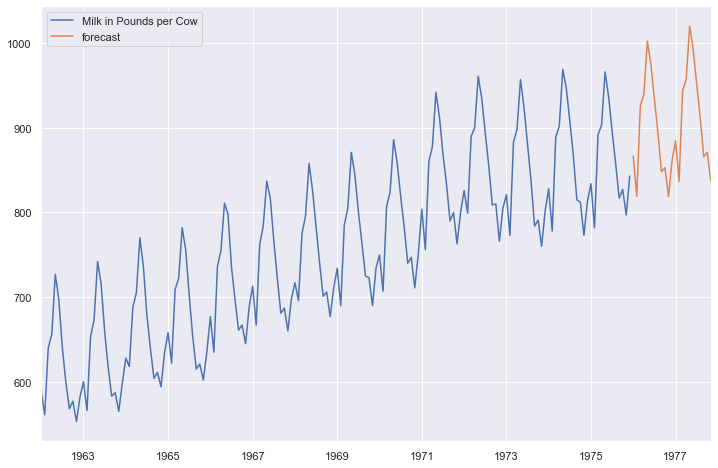

In [66]:
final_df[['Milk in Pounds per Cow', 'forecast']].plot(figsize=(12,8))

In [ ]:
"""
The ARIMA type of prediction model works well when the time value is related to the predicted value
But financial data - such as prices, are influence strongly by other factors besides time
such as other traders being able to trade. This introduces a strong random variation which 
this type of statistical modeling does not deal with very well.

Nevertheless, an interesting learning exercise
"""